## Модель VALENCE-AROUSAL

Эмоциональная детализация - это способность индивида различать специфику своих эмоций. Человек с высокой эмоциональной детализацией способен различать свои эмоции, которые все находятся в пределах одного и того же уровня валентности (Valence) и возбуждения (Arousal), обозначая свои переживания дискретными эмоциональными словами.
Эмоции можно отобразить на диаграмме, моделирующей диапазон возбуждения (от высокого до низкого) и валентности (от удовольствия до неудовольствия), которое испытывается во время определенной эмоции. Например, в правом верхнем углу находятся эмоции с высоким возбуждением и высокой валентностью, включая возбужденное, удивленное, восхищенное, счастливое и довольное. Все эти эмоции являются примерами положительных эмоций, которые вызывают сильное возбуждение. В противоположном углу находится секция низкой валентности и низкого возбуждения, содержащая в качестве некоторых примеров несчастных, подавленных, скучающих и усталых.

![VA.png](https://cloud.telecombg.ru/index.php/s/gZrfCL8wsw6azp6/preview)

## Установка библиотек

In [2]:
!pip install keras_vggface
!pip install keras_applications --no-deps
!pip install livelossplot

## Импорт библиотек

In [1]:
import os
import time
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from livelossplot.tf_keras import PlotLossesCallback
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
print(tf.__version__)

2.4.1


## Загрузка датафреймов с данными

In [2]:
data_folder = Path('./Data')  # base directory

df_train = pd.read_csv(data_folder / 'df_cleared.csv', index_col=0)  # train dataset
df_test = pd.read_csv(data_folder / 'df_test.csv')  # test dataset
df_train.head()

,image_path,emotion,width,height,mode,hash,aspect_ratio,face_count
0,./train/anger/0.jpg,anger,183,183,RGB,f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...,1.0,1
1,./train/anger/1.jpg,anger,749,749,RGB,fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...,1.0,1
2,./train/anger/10.jpg,anger,261,261,RGB,28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...,1.0,1
3,./train/anger/100.jpg,anger,234,234,RGB,b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...,1.0,1
4,./train/anger/1000.jpg,anger,299,299,RGB,36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...,1.0,1


Определим численные соотношения между эмоциями по Valence-Arousal

In [3]:
# The first value - valence, the second one - arousal
VA_mapping = {'anger':    [ -3,    1  ],   # гнев
              'contempt': [ -3.5, -0.5],   # презрение
              'disgust':  [ -1,   -1.8],   # отвращение
              'fear':     [ -1,    2.8],   # страх
              'happy':    [  4,    1  ],   # радость
              'neutral':  [  0,    0  ],   # безразличие
              'sad':      [ -3.5, -1.8],   # грусть
              'surprise': [  3,    2  ],   # удивление
              'uncertain':[  0,   -2  ]}   # неопределенность

Визуализируем эти данные

In [4]:
def emotion_plot(va_data:dict):

    """The function for visualizing emotions by
       Valence-Arousal on the coordinate plane"""

    plt.figure(figsize=(7,7))
    max_value = 0

    for category, (v, a) in va_data.items():
        plt.scatter(v, a, label=category, s=150)
        plt.text(v-0.4, a+0.3, category, size=12)
        max_value = max([max_value, np.abs(v), np.abs(a)])

    x_min, x_max = plt.xlim(-max_value-0.5, max_value + 0.5)
    y_min, y_max = plt.ylim(-max_value-0.5, max_value + 0.5)
    plt.vlines(0, y_min, y_max, linestyle='dashed', lw=1)
    plt.hlines(0, x_min, x_max, linestyle='dashed', lw=1)

    ticks = range(-int(max_value + 0.5), int(max_value + 0.5) + 1)
    plt.xticks(ticks, ticks, size=12)
    plt.yticks(ticks, ticks, size=12)
    plt.grid(alpha=0.9, linestyle='--')
    plt.xlabel('Valence', size=14)
    plt.ylabel('Arousal', size=14)
    plt.title('Emotions in valence-arousal coordinates', size=17)
    plt.show()

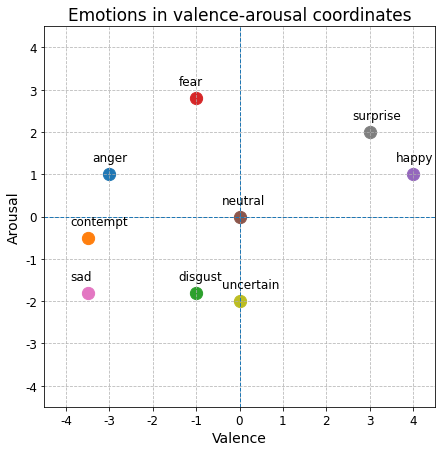

In [5]:
emotion_plot(VA_mapping)

Для обучения модели в valence-arousal разложением эмоций необходима разметка фотографий по этим параметрам. В предоставленном дата-сете такой разметки нет. В связи с этим сгенерируем случайным образом значения пар Valence/Arousal в приблизительно допустимых диапазонах для каждого изображения. Сконструируем соответствующую модель нейронной сети, обучим её на полученных значениях.

In [6]:
def circle (radius):

    """The function for generating random coordinates of a point
    within a circle of a given radius"""

    r = np.random.uniform(low=0, high=radius**2)
    theta = np.random.uniform(low=0, high=2*np.pi)
    x_coord = np.sqrt(r) * np.cos(theta)
    y_coord = np.sqrt(r) * np.sin(theta)
    return x_coord, y_coord

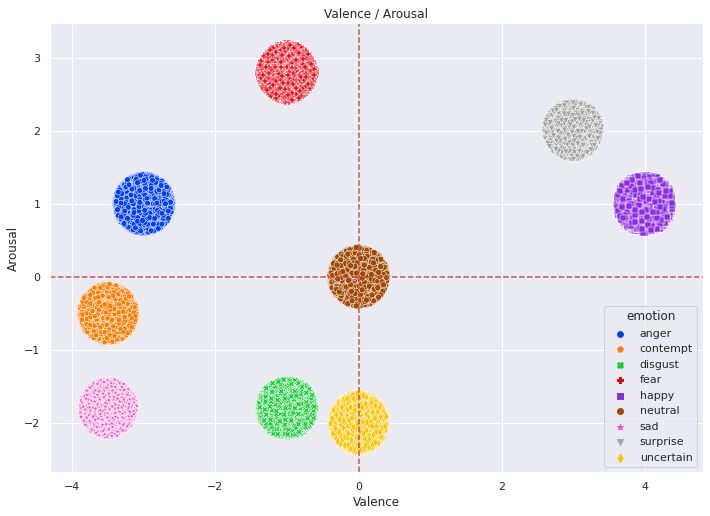

In [7]:
valence = []
arousal = []

for emotion in df_train['emotion']:
    valence_val,arousal_val = circle(0.4)
    valence_val += VA_mapping.get(emotion)[0]
    arousal_val += VA_mapping.get(emotion)[1]
    valence.append(np.round(valence_val, 2))
    arousal.append(np.round(arousal_val, 2))
    
df_train['Valence'] = valence
df_train['Arousal'] = arousal

sns.set(rc={'figure.figsize': (11.7, 8.27)})
markers = {'anger': '8',
           'contempt': 'p', 
           'disgust': 'X',
           'fear': 'P',
           'happy':'s',
           'neutral':'o',
           'sad':'*',
           'surprise':'v',
           'uncertain':'d'}

sns.scatterplot(x='Valence', y='Arousal', data=df_train, 
                hue='emotion', palette='bright', style='emotion', markers=markers)

plt.title('Valence / Arousal')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

df_train.to_csv(data_folder / 'df_cleared_va.csv')

In [8]:
df_train = pd.read_csv(data_folder / 'df_cleared_va.csv', index_col=0)

In [9]:
df_train.head()

,image_path,emotion,width,height,mode,hash,aspect_ratio,face_count,Valence,Arousal
0,./train/anger/0.jpg,anger,183,183,RGB,f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...,1.0,1,-2.92,0.67
1,./train/anger/1.jpg,anger,749,749,RGB,fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...,1.0,1,-2.94,0.74
2,./train/anger/10.jpg,anger,261,261,RGB,28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...,1.0,1,-2.76,0.77
3,./train/anger/100.jpg,anger,234,234,RGB,b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...,1.0,1,-2.75,1.11
4,./train/anger/1000.jpg,anger,299,299,RGB,36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...,1.0,1,-3.19,0.86


Разделим датасет на обучающую и валидационную выборки

In [10]:
def stratified_split_df(dataframe, validation_split=0.1, seed=42):

    """Divides the dataset into test and training samples keeping proportions between classes"""

    random_seed = np.random.RandomState(seed=seed)
    indices = []

    for category in dataframe['emotion'].unique():
        category_df = dataframe[dataframe['emotion'] == category]
        category_df_len = int(category_df.shape[0] * validation_split)
        category_indices = random_seed.choice(category_df.index, size=category_df_len, replace=False)
        indices.extend(list(category_indices))

    train_part = dataframe.drop(indices, axis=0)
    test_part = dataframe.loc[indices,:]

    return train_part, test_part

In [11]:
df_train_va, df_val_va = stratified_split_df(df_train)
df_train_va.to_csv(data_folder / 'df_train_va.csv')
df_val_va.to_csv(data_folder / 'df_val_va.csv')
print(f'Train dataset size: {df_train_va.shape[0]}')
print(f'Validation dataset size: {df_val_va.shape[0]}')

Train dataset size: 44519
Validation dataset size: 4942


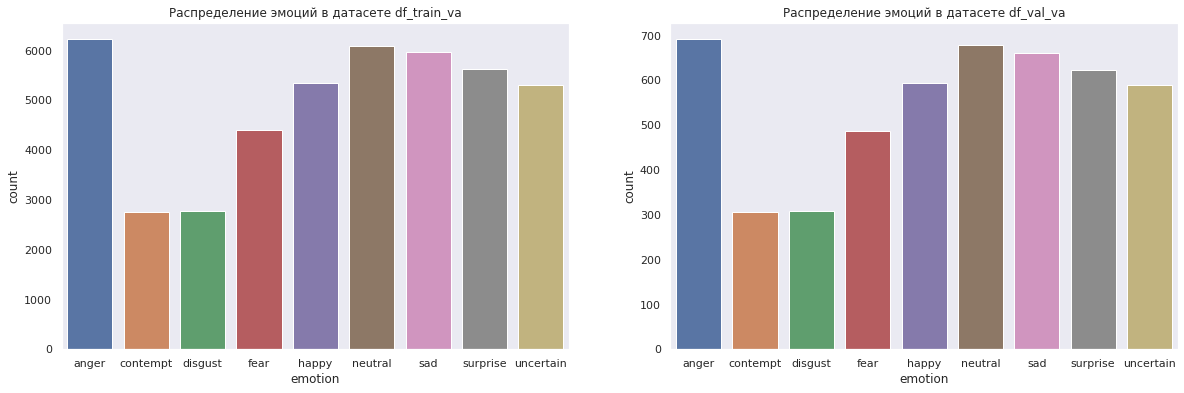

In [12]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.countplot(data = df_train_va, x='emotion').set_title('Распределение эмоций в датасете df_train_va')
plt.grid(axis='y')


plt.subplot(1, 2, 2)
sns.countplot(data = df_val_va, x='emotion').set_title('Распределение эмоций в датасете df_val_va')
plt.grid(axis='y')
plt.show()

In [13]:
def preprocess_vgg(image_):
    
    """image_ - tensor of size (1, H, W, 3)
    return: image, with preprocess_input applied (..., version=2) from keras_vggface"""
    
    preprocessed_image = utils.preprocess_input(image_, version=2)

    return preprocessed_image

In [14]:
def build_generators(train=df_train_va, val=df_val_va, batch_size=16, image_size=224, preprocessing_function_train=preprocess_vgg, preprocessing_function_val=preprocess_vgg):

    """Creates generators for training and validation data with the specified parameters"""

    train_image_generator = ImageDataGenerator(rotation_range=15,
                                               width_shift_range=.15,
                                               height_shift_range=.15,
                                               horizontal_flip=True,
                                               fill_mode='nearest',
                                               brightness_range=(0.6, 1.4),
                                               shear_range=0.2,
                                               preprocessing_function=preprocessing_function_train)

    train_generator = train_image_generator.flow_from_dataframe(dataframe=train,
                                                                x_col='image_path',
                                                                y_col=['Valence','Arousal'],
                                                                target_size=(image_size, image_size),
                                                                batch_size=batch_size,
                                                                class_mode='raw',
                                                                directory=str(data_folder),
                                                                shuffle=True,
                                                                interpolation='nearest',
                                                                validate_filenames=True)

    val_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function_val)

    val_generator = val_image_generator.flow_from_dataframe(dataframe=val,
                                                            directory=str(data_folder),
                                                            x_col='image_path',
                                                            y_col=['Valence','Arousal'],
                                                            target_size=(image_size, image_size),
                                                            batch_size=batch_size,
                                                            class_mode='raw',
                                                            shuffle=True,
                                                            interpolation='nearest',
                                                            validate_filenames=True)

    return train_generator, val_generator

In [15]:
def build_callbacks(save_path:str):

    """Defines Callbacks and their parameters necessary for training models"""

    path = Path(save_path)
    path.mkdir(exist_ok=True)
    cpt_filename = "checkpoint_best.hdf5"
    cpt_path =str(path / cpt_filename)

    model_checkpoint = ModelCheckpoint(cpt_path,
                                       monitor='val_mae',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='min')

    model_lr_reducer = ReduceLROnPlateau(monitor='val_mae',
                                         patience=2,
                                         factor=0.2,
                                         mode='min')

    model_stopper = EarlyStopping(monitor='val_mae', min_delta=0, patience=6, mode='auto')

    return model_checkpoint, model_lr_reducer, model_stopper

In [16]:
train_gen, val_gen = build_generators()

Found 44519 validated image filenames.
Found 4942 validated image filenames.


## Обучение модели

В качестве модели для обучения используем VGG. Сеть VGG, была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Она содержит 3.3 миллиона изображений с 9000 разными персоналиями. [Источник](https://github.com/rcmalli/keras-vggface)

In [17]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [18]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [19]:
vggface_model = tf.keras.Sequential([vggface_model,
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(2, activation='linear')])
vggface_model.build(input_shape=(None, 224, 224, 3))
vggface_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 23,512,130
Non-trainable params: 53,120
_________________________________________________________________


In [20]:
vggface_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                      loss='mse',
                      metrics='mae')

In [21]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_va")

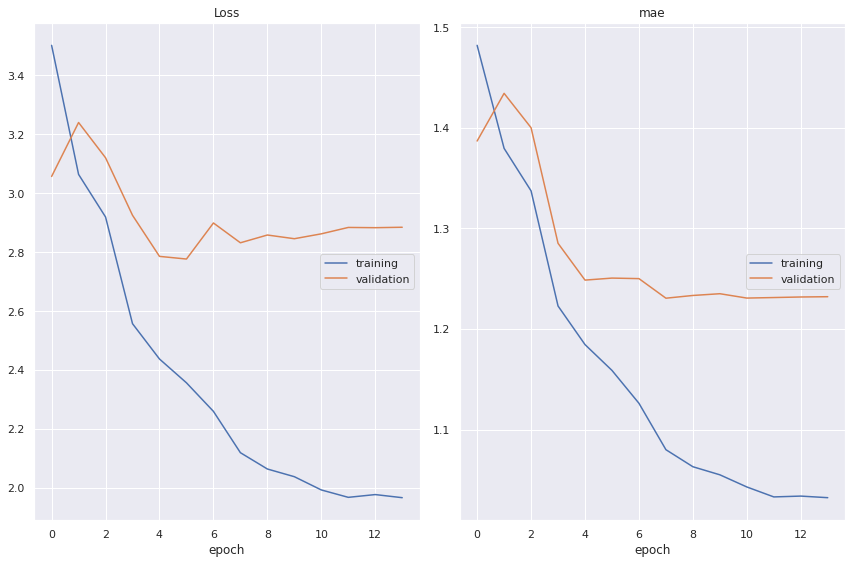

Loss
	training         	 (min:    1.966, max:    3.502, cur:    1.966)
	validation       	 (min:    2.777, max:    3.240, cur:    2.885)
mae
	training         	 (min:    1.032, max:    1.482, cur:    1.032)
	validation       	 (min:    1.231, max:    1.434, cur:    1.232)

Epoch 00014: val_mae did not improve from 1.23057


In [24]:
fitter = vggface_model.fit(train_gen,
                           epochs=20,
                           validation_data=val_gen,
                           callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [25]:
vggface_model.save('./saved_model_va/1')

INFO:tensorflow:Assets written to: ./saved_model_va/1/assets


In [26]:
vggface_model = tf.keras.models.load_model('./saved_model_va/1')
vggface_model.evaluate(val_gen)

309/309 [==============================] - 29s 92ms/step - loss: 2.8280 - mae: 1.2315


[2.8279855251312256, 1.2315309047698975]

In [27]:
def deprocess_image(vggface_image):
    
    """
    vggface_image -- (H, W, 3) image after preprocessing. 
    contains negative values and the matplotlib is displayed incorrectly

    return: a correctly displayed image of the type np.uint8 (!!). 

    ! work with a copy of the image (image = np. copy(vggface_image))!
    """
    
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)
    
    return image

In [28]:
def get_emotion(v, a, scale=0.4):
    
    """The function for converting numeric values by Valence-Arousal to emotion"""
    
    for emotion in VA_mapping.keys():
        if (VA_mapping[emotion][0]-scale <= v <= VA_mapping[emotion][0]+scale) and (VA_mapping[emotion][1]-scale <= a <= VA_mapping[emotion][1]+scale):
            return emotion
            break
    else:
        return "Unknown"

In [29]:
def show_faces(images, labels_v=None, labels_a=None, predicted_v=None, predicted_a=None):
    
    """The function for displaying a series of images with real and predicted class labels"""
    
    plt.figure(figsize=(10,10))
    f_labels = {"Emotion": [predicted_v, predicted_a, labels_v, labels_a]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predict_v, predict_a, label_v, label_a) in f_labels.items():
            if predict_v is None:
                continue
                
            else:
                real_emotion = get_emotion(label_v[i], label_a[i])
                dot = np.array((predict_v[i], predict_a[i])).ravel()
                distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
                min_index = np.argmin(distances)              
                predicted_emotion = list(VA_mapping.keys())[min_index]
                real_str += f"{real_emotion}, "
                pred_str += f"{predicted_emotion}, "
                if real_emotion != predicted_emotion:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

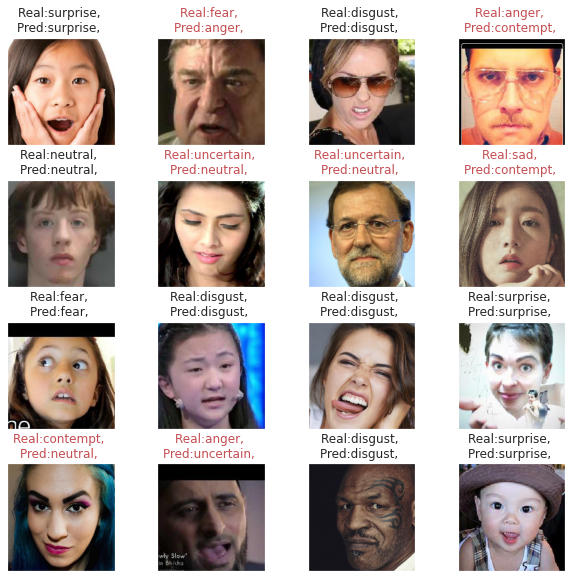

In [30]:
sample_validation_images, sample_validation_labels = next(val_gen)
predicted = vggface_model.predict(sample_validation_images)

sample_validation_labels = np.hsplit(sample_validation_labels, 2)
predicted = np.hsplit(predicted, 2)

show_faces(images=sample_validation_images, 
           labels_v=sample_validation_labels[0],
           labels_a=sample_validation_labels[1],
           predicted_v=predicted[0],
           predicted_a=predicted[1])

## Предикт на тренировочных данных

Сделаем предсказание на тренировочных данных и посмотрим на распределение меток класса

In [50]:
va_pred = []
valence_pred = []
arousal_pred = []

for file in tqdm(df_train.image_path):
    img = image.load_img(data_folder / file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_vgg(x)
    predicts = vggface_model.predict(x)
    dot = predicts.ravel()
    distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
    min_index = np.argmin(distances)
    va_pred.append(list(VA_mapping.keys())[min_index])
    valence_pred.append(dot[0])
    arousal_pred.append(dot[1])
    
df_train['va_pred'] = va_pred
df_train['valence_pred'] = valence_pred
df_train['arousal_pred'] = arousal_pred
    
df_train.to_csv(data_folder / 'df_cleared_va_pred.csv')

100%|██████████| 49461/49461 [41:21<00:00, 19.93it/s] 


In [31]:
df_train = pd.read_csv(data_folder / 'df_cleared_va_pred.csv', index_col=0)
df_train.head()

,image_path,emotion,width,height,mode,hash,aspect_ratio,face_count,va_pred,valence_pred,arousal_pred
0,./train/anger/0.jpg,anger,183,183,RGB,f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...,1.0,1,fear,-1.396129,2.134857
1,./train/anger/1.jpg,anger,749,749,RGB,fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...,1.0,1,anger,-2.124361,0.370593
2,./train/anger/10.jpg,anger,261,261,RGB,28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...,1.0,1,anger,-2.118507,0.622897
3,./train/anger/100.jpg,anger,234,234,RGB,b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...,1.0,1,anger,-3.065423,0.459863
4,./train/anger/1000.jpg,anger,299,299,RGB,36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...,1.0,1,neutral,-1.654502,-0.141210


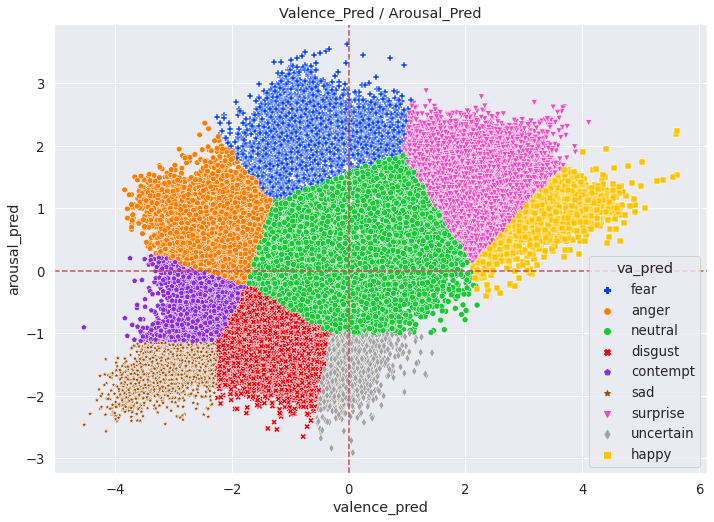

In [32]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='valence_pred', y='arousal_pred', data=df_train,
                hue='va_pred', palette='bright', style='va_pred', markers=markers)
plt.title('Valence_Pred / Arousal_Pred')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

## Предикт на тестовых данных

Сделаем предсказание на тестовых данных

In [33]:
va_pred = []
valence_pred = []
arousal_pred = []

for file in tqdm(df_test.image_path):
    img = image.load_img(data_folder / 'test_kaggle' / file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_vgg(x)
    predicts = vggface_model.predict(x)
    dot = predicts.ravel()
    distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
    min_index = np.argmin(distances)
    va_pred.append(list(VA_mapping.keys())[min_index])
    valence_pred.append(dot[0])
    arousal_pred.append(dot[1])
    
df_test['emotion'] = va_pred
df_test['valence_pred'] = valence_pred
df_test['arousal_pred'] = arousal_pred
    
df_test.to_csv(data_folder / 'df_test_va_pred.csv')
df_test[['image_path','emotion']].to_csv(data_folder / 'df_test_va_submission.csv', index=False)

100%|██████████| 5000/5000 [04:48<00:00, 17.33it/s]


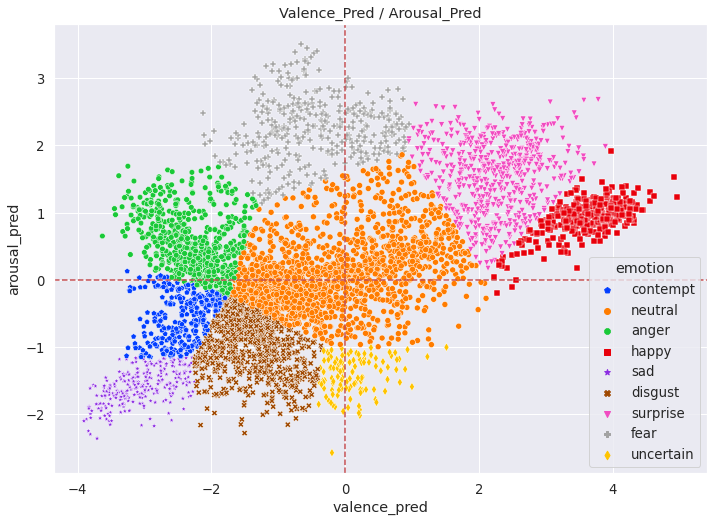

In [34]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='valence_pred', y='arousal_pred', data=df_test,
                hue='emotion', palette='bright', style='emotion', markers=markers)
plt.title('Valence_Pred / Arousal_Pred')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

## Score on Kaggle

Результаты:
- Public Score: 0.44040
- Private Score: 0.42280

![VA.png](https://cloud.telecombg.ru/index.php/s/WGcZ2kkf8PLpYpf/preview)